# Test Notebook, um Tainingsdaten zu annotieren
Autor: Thomas Fetter 

Output()

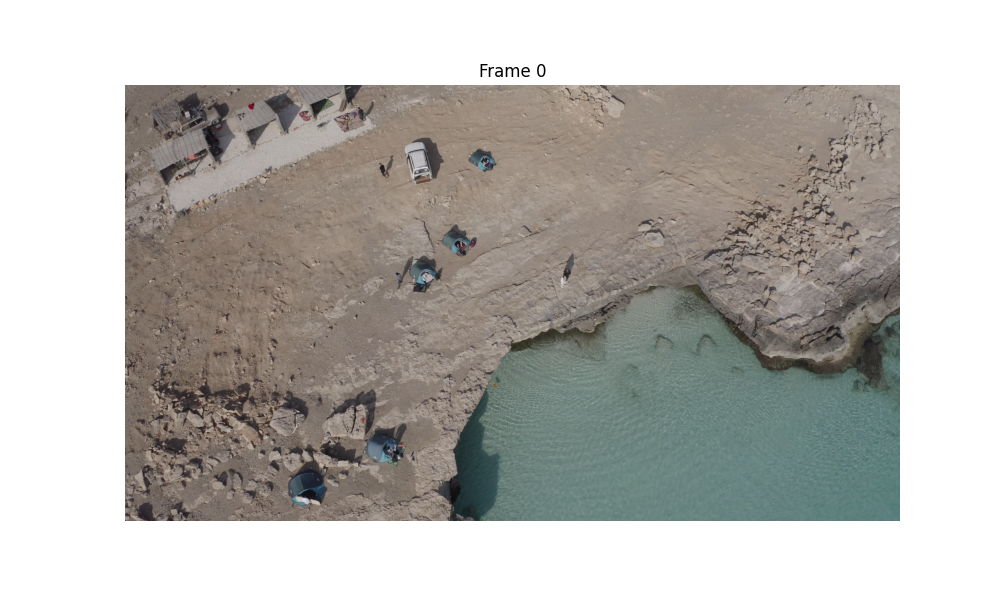

In [1]:
%matplotlib widget

# Interaktives YOLOv8 + DeepSORT Labeling-Tool mit Tracking-basierter Ignorierung

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from deep_sort_realtime.deepsort_tracker import DeepSort

# === KONFIGURATION ===
video_folder = "data/demo_mat/"
supported_formats = ('.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv', '.webm')
model = YOLO("yolov8l.pt")  # oder yolov8n.pt, wenn leichtgewichtiger
tracker = DeepSort(max_age=30)  # neue Tracker-Instanz

# === VIDEO FINDEN ===
def find_video(folder, extensions):
    for file in os.listdir(folder):
        if file.lower().endswith(extensions):
            return os.path.join(folder, file)
    return None

video_path = find_video(video_folder, supported_formats)
if video_path is None:
    raise FileNotFoundError("Kein Video gefunden im Ordner /files")
cap = cv2.VideoCapture(video_path)

# === GLOBAL ===
annotations = []           # finale Annotationen
manual_boxes = []          # manuell gezeichnete Boxen
current_yolo_boxes = []    # Vorschlaege von YOLO mit Tracking
ignored_tracks = []        # Liste ignorierter {track_id, label}
current_frame_index = 0
click_state = []           # [x1, y1] oder leer

# === FIGURE INITIALISIEREN ===
fig, ax = plt.subplots(figsize=(10, 6))  # bleibt bestehen

# === UI ELEMENTE ===
frame_slider = widgets.IntSlider(min=0, max=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1, step=1, description="Frame:")
save_button = widgets.Button(description="💾 Speichern")
next_button = widgets.Button(description="⏭ Weiter")
rerun_button = widgets.Button(description="🔁 YOLO neu ausfuehren")
label_dropdown = widgets.Dropdown(options=["person", "car", "truck", "bus", "motorbike"], description="Label:")
output = widgets.Output()

# === HILFSMETHODEN ===
def get_frame(index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    if not success:
        raise ValueError(f"Frame {index} nicht lesbar")
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def rerun_yolo():
    global current_yolo_boxes
    frame = get_frame(current_frame_index)
    results = model.predict(frame, verbose=False)
    detections = []

    for r in results:
        for box in r.boxes:
            conf = float(box.conf[0])
            label = model.names[int(box.cls[0])]
            if conf > 0.5 and label in label_dropdown.options:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                detections.append(([x1, y1, x2 - x1, y2 - y1], conf, label))

    tracks = tracker.update_tracks(detections, frame=frame)
    current_yolo_boxes = []

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        label = track.get_det_class()
        if any(t['track_id'] == track_id and t['label'] == label for t in ignored_tracks):
            continue  # überspringen, wenn ignoriert
        x1, y1, x2, y2 = map(int, ltrb)
        current_yolo_boxes.append({
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "label": label, "track_id": track_id,
            "source": "yolo"
        })

def redraw():
    frame = get_frame(current_frame_index)
    ax.clear()
    ax.imshow(frame)
    ax.set_title(f"Frame {current_frame_index}")

    # YOLO-Boxen mit Tracking zeichnen
    for box in current_yolo_boxes:
        draw_box(ax, box, color='lime', textcolor='white', track_id=box.get("track_id"))

    # manuelle Boxen
    for box in manual_boxes:
        if box["frame"] == current_frame_index:
            draw_box(ax, box, color='orange', textcolor='orange', linestyle='--')

    # ggf. Klickpunkt
    if click_state:
        ax.plot(click_state[0], click_state[1], 'rx', markersize=10)

    ax.axis("off")
    fig.canvas.draw()

def draw_box(ax, box, color, textcolor, linestyle='-', track_id=None):
    x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                     edgecolor=color, facecolor='none', linestyle=linestyle)
    ax.add_patch(rect)
    label = box['label']
    if track_id is not None:
        label += f" #{track_id}"
    ax.text(x1, y1 - 5, label, color=textcolor, backgroundcolor='black')

def onclick(event):
    global click_state
    if event.inaxes != ax: return
    x, y = int(event.xdata), int(event.ydata)

    # Box löschen → track_id ignorieren
    for lst in [current_yolo_boxes, manual_boxes]:
        for box in lst:
            if (box.get("frame", current_frame_index) == current_frame_index and
                box['x1'] <= x <= box['x2'] and box['y1'] <= y <= box['y2']):
                if box.get("track_id") is not None:
                    ignored_tracks.append({"track_id": box["track_id"], "label": box["label"]})
                lst.remove(box)
                redraw()
                return

    # Neue Box starten / abschließen
    if not click_state:
        click_state = [x, y]
    else:
        new_box = {
            "frame": current_frame_index,
            "x1": min(click_state[0], x), "y1": min(click_state[1], y),
            "x2": max(click_state[0], x), "y2": max(click_state[1], y),
            "label": label_dropdown.value,
            "source": "manual"
        }
        manual_boxes.append(new_box)
        click_state = []
    redraw()

# === CALLBACKS ===
def on_frame_change(change):
    global current_frame_index, click_state
    current_frame_index = change['new']
    click_state = []
    rerun_yolo()
    redraw()

def on_save_click(_):
    annotations.extend(current_yolo_boxes)
    annotations.extend([b for b in manual_boxes if b["frame"] == current_frame_index])
    with output:
        print(f"✅ Frame {current_frame_index} gespeichert.")

def on_next_click(_):
    if frame_slider.value < frame_slider.max:
        frame_slider.value += 1

def on_rerun_click(_):
    rerun_yolo()
    redraw()

# === EVENTS VERBINDEN ===
frame_slider.observe(on_frame_change, names="value")
save_button.on_click(on_save_click)
next_button.on_click(on_next_click)
rerun_button.on_click(on_rerun_click)
fig.canvas.mpl_connect('button_press_event', onclick)

# === UI ZEIGEN ===
display(widgets.HBox([frame_slider, label_dropdown, save_button, next_button, rerun_button]))
display(output)
rerun_yolo()
redraw()
plt.show()

# === EXPORT (optional) ===
# df = pd.DataFrame(annotations + manual_boxes)
# df.to_csv(os.path.join(video_folder, "final_labels.csv"), index=False)
# print("📁 CSV gespeichert unter final_labels.csv")
